# Промышленность

## Предсказание конечной температуры сплава

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### Обработаем `data_arc` и соеденим его с другими датафреймами (data_bulk, data_gas, data_wire)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_arc = pd.read_csv(r'..\data\raw\data_arc.csv')

In [3]:
df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [4]:
display(df_arc.info())
display(df_arc.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Сразу обработаем отрицательное значение в реактивной мощности, как аномалию.

In [5]:
df_arc[df_arc['Реактивная мощность'] < 0] = df_arc['Реактивная мощность'].mean()

Создадим новый признак - энергия затрачиваемая на каждую стадию:
 $$ Q=\sqrt{(Pactive)^2 + (Preactive)^2} \over t $$ 

In [6]:
from src.features.Q_calculation import energy_calculation

In [7]:
energy_calculation(df_arc, 'Energy')

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Energy
0,1.0,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,221.543751
1,1.0,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,136.121974
2,1.0,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,121.331787
3,1.0,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,548.537138
4,1.0,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,86.734837
...,...,...,...,...,...,...
14871,3241.0,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,78.696565
14872,3241.0,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,133.294632
14873,3241.0,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,123.772355
14874,3241.0,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,11.750416


Суммируем все данные по каждому образцу и оставляем только номер образца и количество энергии, затрачиваемое на его обработку, исключая остальные данные для дальнейшего объединения наших датафреймов.

In [8]:
from src.data.datamerge import dfprep

In [9]:
df_total = dfprep(df_arc, 'key')

Мёрджим все датафрейми к основному df_arc для дальнейшей обработки.

In [10]:
from src.data.datamerge import readcsvs
from src.data.datalist import csvlist
from src.data.datamerge import mergecsvs


In [11]:
csvs = readcsvs(csvlist)
df_total = mergecsvs(df_total, csvs)

In [12]:
display(df_total.head())
df_total.info()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Energy
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,...,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1114.269487
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,...,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,689.557348
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,...,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,397.304683
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,...,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,608.021227
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,...,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,940.367293


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 0 to 3128
Data columns (total 27 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
 16  Газ 1    3127 non-null   float64
 17  Wire 1   3000 non-null   float64
 18  Wire 2   1051 non-null   float64
 19  Wire 3   63 non-null     float64
 20  Wire 4   14 non-null     float64
 21  Wire 5   1 non

Заполним пропуска и переименуем колонки с русского на английский.

In [13]:
from src.data.datamerge import dfprepar
df_total = dfprepar(df_total,'Газ 1')

In [14]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 0 to 3128
Data columns (total 27 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 2   3129 non-null   float64
 3   Bulk 3   3129 non-null   float64
 4   Bulk 4   3129 non-null   float64
 5   Bulk 5   3129 non-null   float64
 6   Bulk 6   3129 non-null   float64
 7   Bulk 7   3129 non-null   float64
 8   Bulk 8   3129 non-null   float64
 9   Bulk 9   3129 non-null   float64
 10  Bulk 10  3129 non-null   float64
 11  Bulk 11  3129 non-null   float64
 12  Bulk 12  3129 non-null   float64
 13  Bulk 13  3129 non-null   float64
 14  Bulk 14  3129 non-null   float64
 15  Bulk 15  3129 non-null   float64
 16  Gas      3129 non-null   float64
 17  Wire 1   3129 non-null   float64
 18  Wire 2   3129 non-null   float64
 19  Wire 3   3129 non-null   float64
 20  Wire 4   3129 non-null   float64
 21  Wire 5   3129 

### Обработаем `data_temp` и соеденим его с `df_total` для дальнейшей изучения 

In [15]:
df_temp = pd.read_csv(r'..\data\raw\data_temp.csv')
df_temp.columns = ['key', 'Time', 'Temperature']

In [16]:
print(df_temp.head(20))
display(df_temp.info())
display(df_temp.describe())

    key                 Time  Temperature
0     1  2019-05-03 11:16:18       1571.0
1     1  2019-05-03 11:25:53       1604.0
2     1  2019-05-03 11:29:11       1618.0
3     1  2019-05-03 11:30:01       1601.0
4     1  2019-05-03 11:30:39       1613.0
5     2  2019-05-03 11:37:27       1581.0
6     2  2019-05-03 11:38:00       1577.0
7     2  2019-05-03 11:49:38       1589.0
8     2  2019-05-03 11:55:50       1604.0
9     2  2019-05-03 11:58:24       1608.0
10    2  2019-05-03 11:59:12       1602.0
11    3  2019-05-03 12:13:17       1596.0
12    3  2019-05-03 12:18:36       1597.0
13    3  2019-05-03 12:25:06       1598.0
14    3  2019-05-03 12:30:48       1599.0
15    3  2019-05-03 12:34:57       1599.0
16    4  2019-05-03 12:52:57       1601.0
17    4  2019-05-03 12:58:43       1623.0
18    4  2019-05-03 12:59:25       1625.0
19    5  2019-05-03 13:23:19       1576.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Colum

None

,key,Temperature
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [17]:
print(df_temp['key'].value_counts())

46      16
1214    16
44      16
1513    16
2108    15
        ..
1160     2
982      2
2456     2
195      1
279      1
Name: key, Length: 3216, dtype: int64


In [18]:
from src.data.datatemp import dfpreptemp

У каждой партии происходит несколько стадий обработки до состояния готового продукта. Соотвественно, нас интересуют те образцы, по которым минимум 2 замера температуры и образцы, по которым есть первый и последний замеры температуры.

In [19]:
df_total = dfpreptemp(df_temp, df_total, df_temp.columns, ['key', 'Initial Temp', 'Final Temp'])

In [20]:
df_total.reset_index()

,index,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,...,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Energy,Initial Temp,Final Temp
0,0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1114.269487,1571.0,1613.0
1,1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,689.557348,1581.0,1602.0
2,2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,397.304683,1596.0,1599.0
3,3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,608.021227,1601.0,1625.0
4,4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,940.367293,1576.0,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2403,2403,2495,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,654.176286,1570.0,1591.0
2404,2404,2496,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,687.084441,1554.0,1591.0
2405,2405,2497,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,504.643758,1571.0,1589.0
2406,2406,2498,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,620.706245,1591.0,1594.0


In [21]:
from src.data.datamerge import missing
missing(df_total)
pd.set_option('display.max_rows', None)

              missing_values  % of total
key                        0         0.0
Bulk 15                    0         0.0
Initial Temp               0         0.0
Energy                     0         0.0
Wire 9                     0         0.0
Wire 8                     0         0.0
Wire 7                     0         0.0
Wire 6                     0         0.0
Wire 5                     0         0.0
Wire 4                     0         0.0
Wire 3                     0         0.0
Wire 2                     0         0.0
Wire 1                     0         0.0
Gas                        0         0.0
Bulk 14                    0         0.0
Bulk 1                     0         0.0
Bulk 13                    0         0.0
Bulk 12                    0         0.0
Bulk 11                    0         0.0
Bulk 10                    0         0.0
Bulk 9                     0         0.0
Bulk 8                     0         0.0
Bulk 7                     0         0.0
Bulk 6          

In [22]:
from src.features.vizual import boxplotss

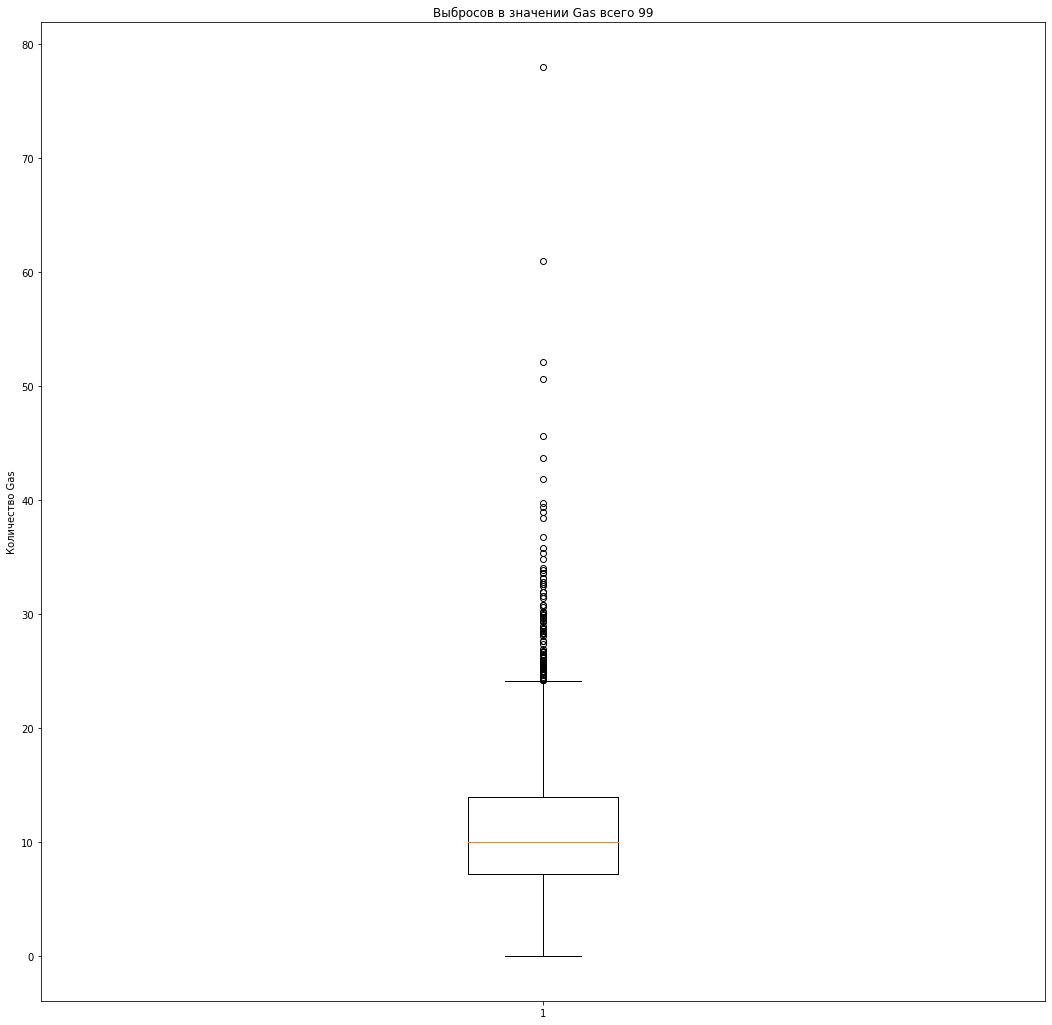

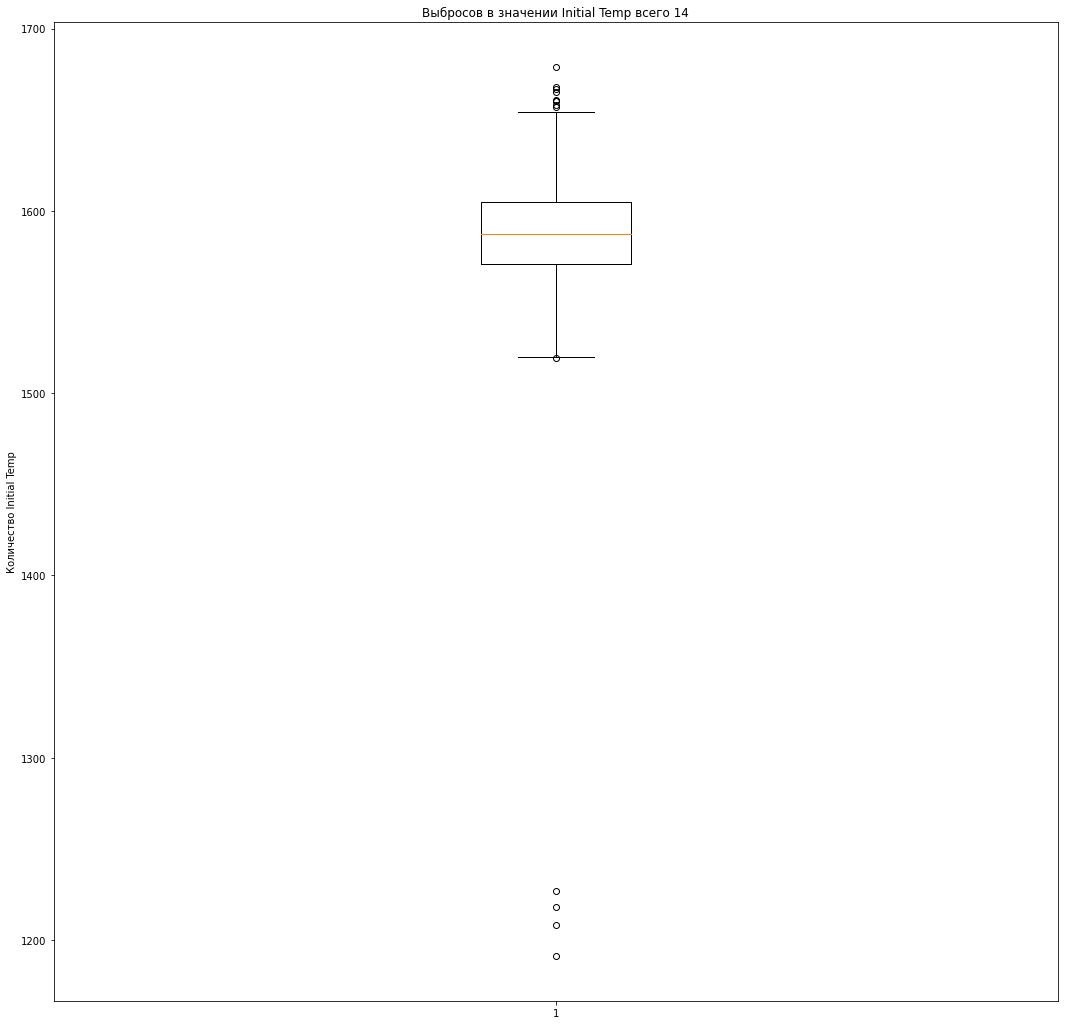

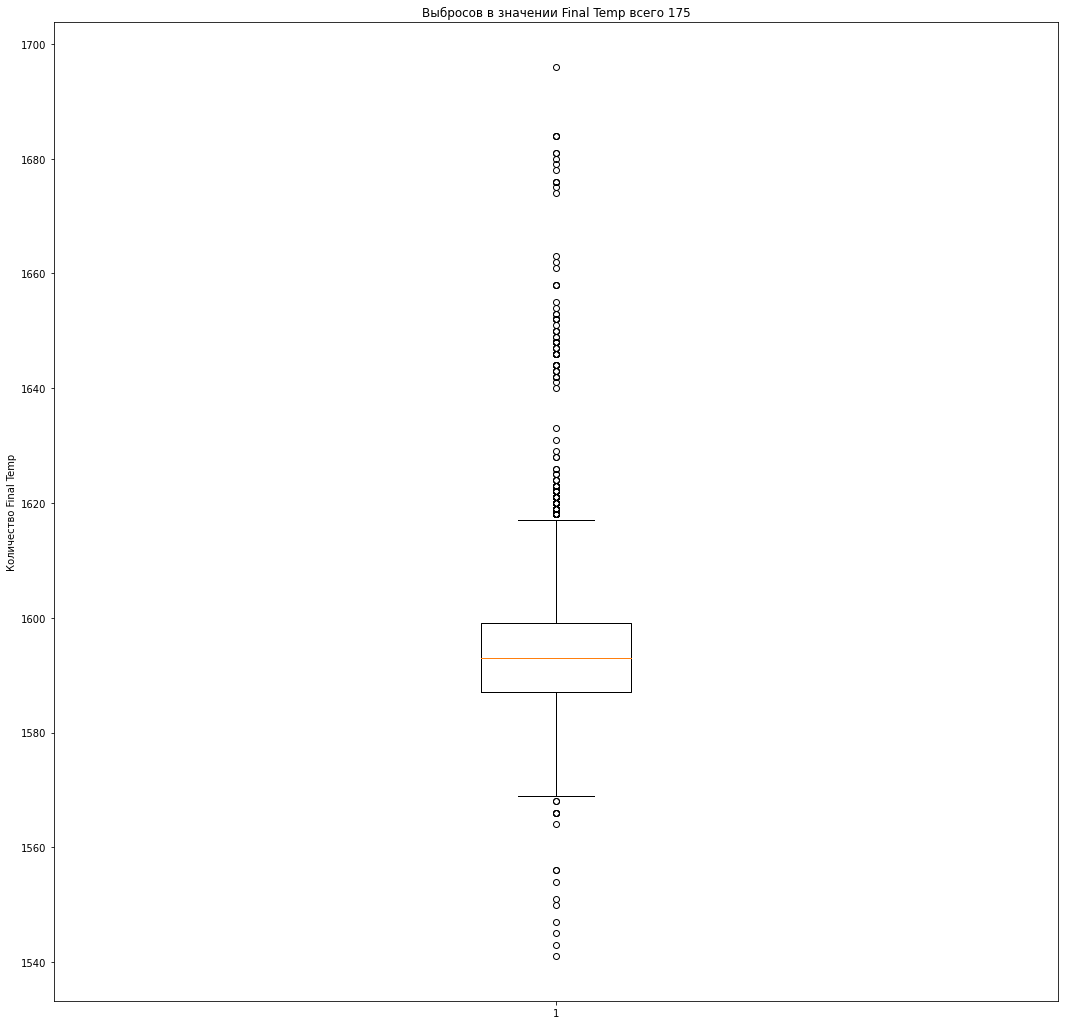

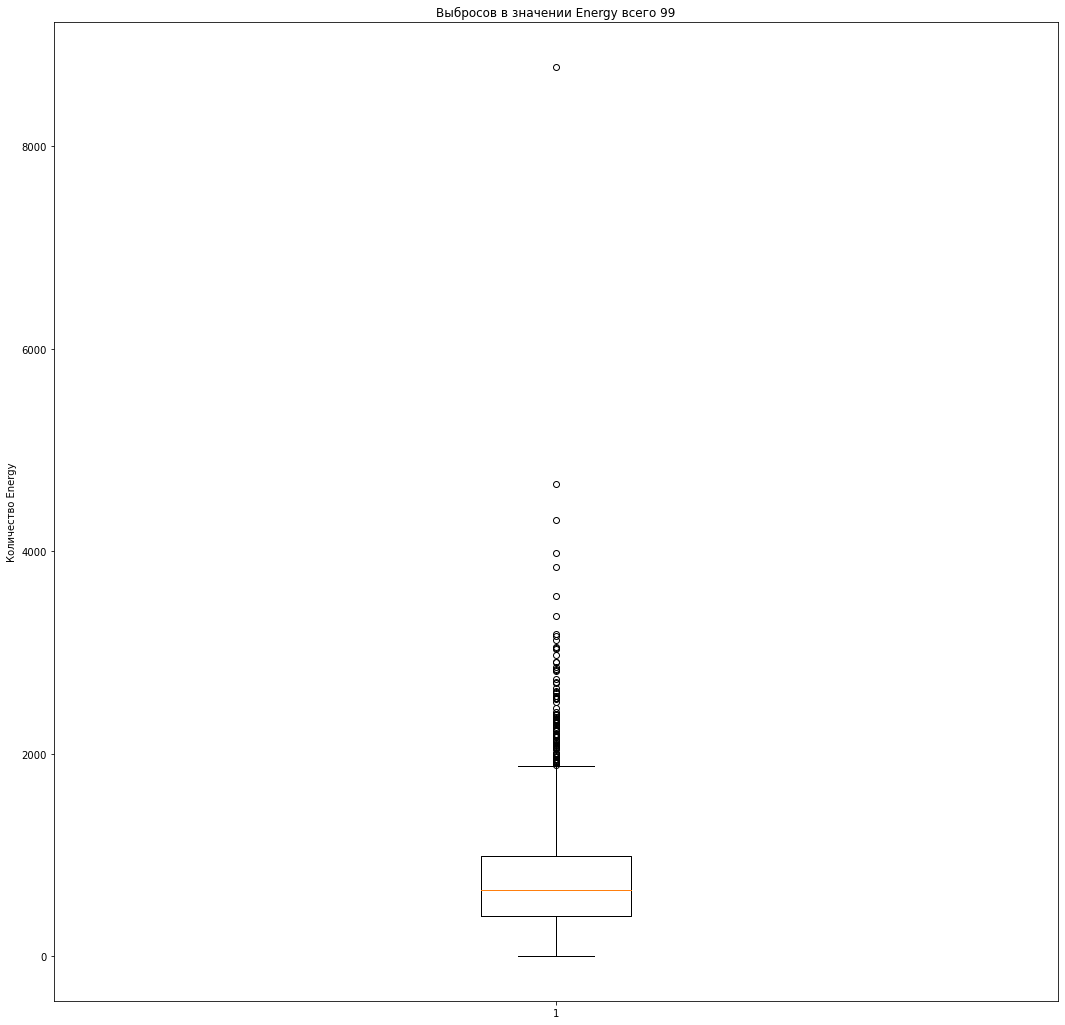

In [23]:
boxplotss(df_total, ['Gas', 'Initial Temp', 'Final Temp', 'Energy'], r'..\reports\figures')

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import numpy as np
import copy
import pandas as pd

In [26]:
target = df_total['Final Temp']
features = df_total.drop('Final Temp', axis=1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

scaler = StandardScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test) 

Mae Lasso: 7.920207586974309


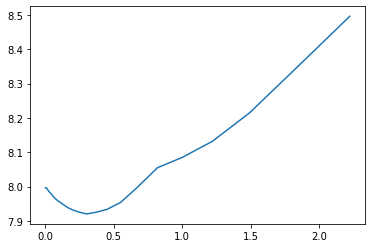

In [27]:
from sklearn.linear_model import Lasso

alphas = np.exp(np.arange(-10, 1, 0.2))
errors = []
for alpha in alphas:
    ls = Lasso(alpha=alpha, random_state = 12345)
    ls.fit(features_train, target_train)
    LR_predict = ls.predict(features_test) 
    Imae_LS = mean_absolute_error(target_test, LR_predict)
    errors.append(Imae_LS)
    
print('Mae Lasso:', min(errors))
plt.plot(alphas, errors)

In [28]:
df_total_nl = copy.deepcopy(df_total)

In [29]:
from src.models.models import model_learning
resuling_df = model_learning(df_total_nl,'Final Temp')

TypeError: model_learning() missing 1 required positional argument: 'modellist'

In [32]:
target = df_total_nl['Final Temp']
features = df_total_nl.drop('Final Temp', axis=1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [33]:
model_RFR = RandomForestRegressor(random_state=12345)
model_RFR.fit(features_train, target_train)
RFR_predict = model_RFR.predict(features_test)
Imae_RFR = mean_absolute_error(target_test, RFR_predict)
print('mae: %.2f градусов' % (Imae_RFR))
print(df_total['Final Temp'].mean())

mae: 6.78 градусов
1594.8816445182724


CPU times: total: 0 ns
Wall time: 0 ns


C:\Users\User\.conda\envs\cookiecutter\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(


(RandomForestRegressor(criterion='mae', max_depth=4, n_estimators=50,
                      random_state=12345), 7.258471760797343)


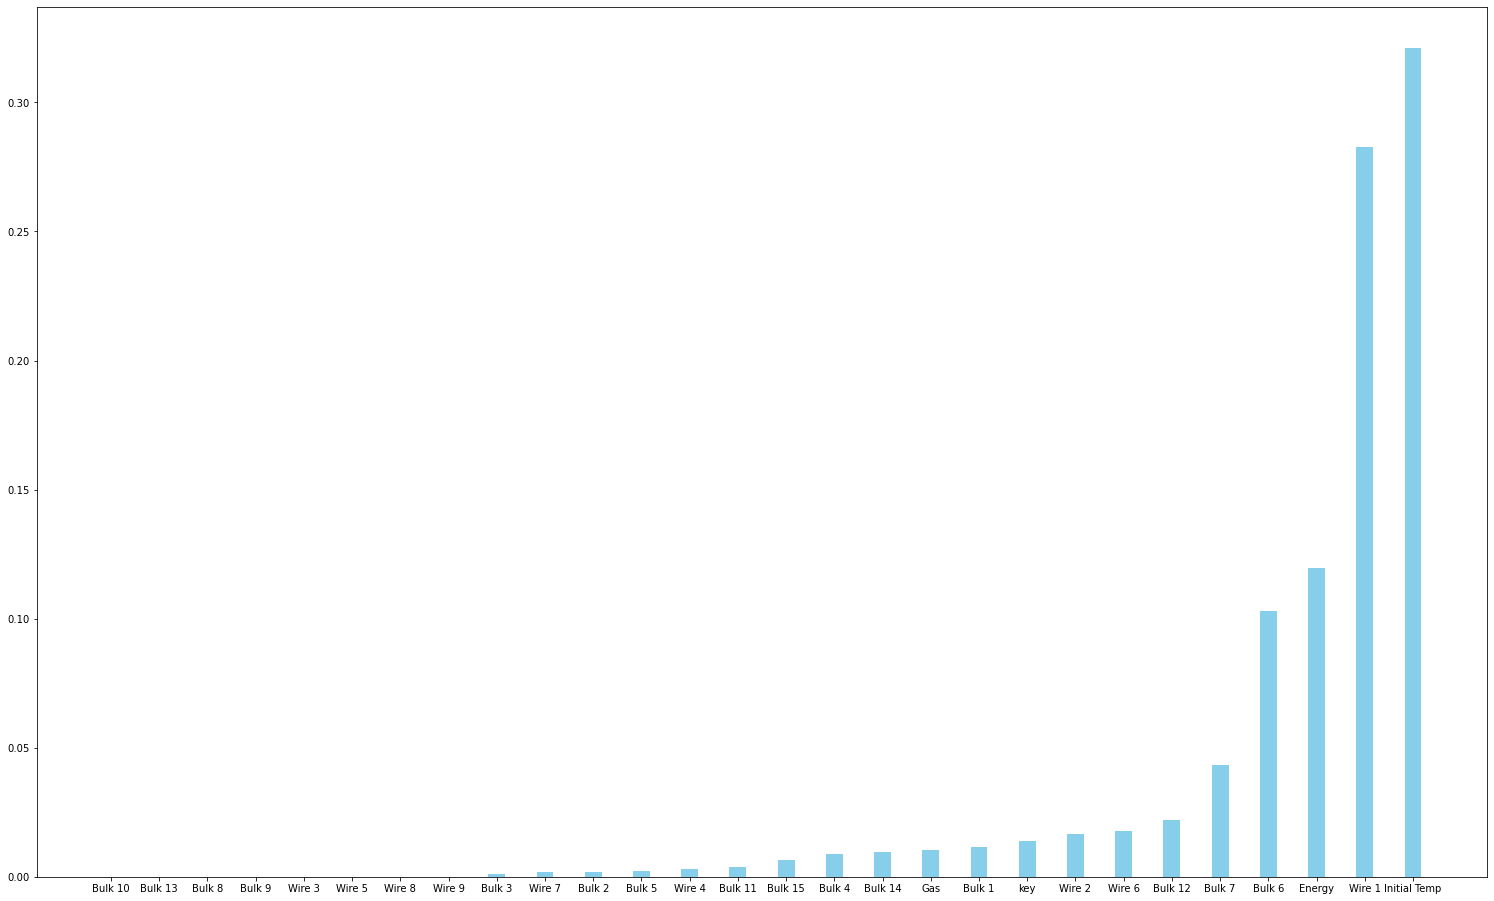

In [40]:
%time
model_RFR_L = RandomForestRegressor(random_state=12345)
parameters_RFR = {'max_depth' : list(range(2, 6, 2)),
                  'n_estimators': list(range(50, 200, 50)),
                  'criterion' : ['mae'],
                 }

def model_parameters(f_train, t_train, f_test, t_test, model, parameters):
    Mmodel = GridSearchCV(model, param_grid = parameters_RFR, n_jobs = -1, cv = 5)
    Mmodel.fit(f_train, t_train)
    MP = Mmodel.best_estimator_
    predictions_RFR = MP.predict(f_test)
    mae_RFR = mean_absolute_error(t_test, predictions_RFR)
    feature_importances = sorted(list(zip(MP.feature_importances_, features.columns)), reverse=False)
    plt.figure(figsize=(26, 16))
    plt.bar(height = list(map(lambda x: x[0], feature_importances)), x =list(map(lambda x: x[1], feature_importances)), width = 0.35, color='skyblue')
    return (MP, mae_RFR)
print(model_parameters(features_train, target_train, features_test, target_test, model_RFR_L, parameters_RFR))

In [ ]:
Model_list = [linear, RFR]
model_parameters = 